# 1. Prepare the compatible environment

In [1]:
# Return to compatible financial_phrasebank combination（datasets 2.x）
%pip uninstall -y datasets fsspec gcsfs bigframes pyarrow apache-beam


Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
Found existing installation: gcsfs 2025.3.0
Uninstalling gcsfs-2025.3.0:
  Successfully uninstalled gcsfs-2025.3.0
Found existing installation: bigframes 2.24.0
Uninstalling bigframes-2.24.0:
  Successfully uninstalled bigframes-2.24.0
Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully uninstalled pyarrow-18.1.0


In [2]:
%pip install -q "datasets==2.19.1" "pyarrow==16.1.0" \
  "transformers==4.44.2" "accelerate>=0.33.0" peft scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.0 MB/s eta 0:00:00


In [ ]:
# Force a restart to clear the loaded C extension
import os; os.kill(os.getpid(), 9)




# 2. Model Config Settings

In [1]:
# ================================================================
# Financial Sentiment Classification (Bullish / Bearish / Neutral)
# Models: BERT-base vs FinBERT
# Methods: Full Fine-tuning vs LoRA (parameter-efficient)
# Colab-ready, memory-friendly
# ================================================================

import os, time, random, math
import numpy as np
import pandas as pd
from collections import Counter
from typing import Dict
from pathlib import Path

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)
from datasets import load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from peft import LoraConfig, get_peft_model, TaskType

# -----------------------------
# config
# -----------------------------
SEED = 42
set_seed(SEED)

DATASET_CONFIG = "sentences_50agree"   # Financial PhraseBank
TEXT_FIELD = "sentence"
LABEL_FIELD = "label"

# Resource-friendly Settings
BATCH_SIZE = 8                       # small batch in order to prevent OOM
EPOCHS = 4                           # 4 is enough for converge
LR_FULL = 2e-5
LR_LORA = 1e-4
MAX_LENGTH = 128
WEIGHT_DECAY = 0.01
GRAD_ACC_STEPS = 2                   # Gradient accumulation, further saves video memory
USE_FP16 = bool(torch.cuda.is_available())

# LoRA congfig
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.1
LORA_TARGET_MODULES = ["query", "key", "value", "dense"]

MODEL_NAMES = [
    "bert-base-uncased",   # baseline model
    "ProsusAI/finbert"     # financial domain
]

OUTPUT_DIR = Path.cwd() / "Assignment3_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUTPUT_DIR.resolve())



Saving to: /content/Assignment3_outputs


# 3. Data Cleaning and Processing

In [2]:
# -----------------------------
# 1) Load the dataset and split it
# -----------------------------
print(">> Loading Financial PhraseBank ...")
ds_raw = load_dataset("financial_phrasebank", DATASET_CONFIG)  # 通常只有 'train' split

# 80/10/10 split
if "validation" not in ds_raw or "test" not in ds_raw:
    tmp = ds_raw["train"].train_test_split(test_size=0.2, seed=SEED)
    tmp2 = tmp["test"].train_test_split(test_size=0.5, seed=SEED)
    ds = DatasetDict(train=tmp["train"], validation=tmp2["train"], test=tmp2["test"])
else:
    ds = ds_raw

# Label mapping：positive/negative/neutral -> 0/1/2
str2id = {"positive": 0, "negative": 1, "neutral": 2}
id2name = {0: "Bullish", 1: "Bearish", 2: "Neutral"}

def map_label(example):
    val = example[LABEL_FIELD]
    if isinstance(val, str):
        return {"label_id": str2id[val]}
    # 0/1/2 will be reflected to Bullish/Bearish/Neutral
    return {"label_id": int(val)}

ds = ds.map(map_label)

def show_dist(split_name):
    cnt = Counter(int(x["label_id"]) for x in ds[split_name])
    print(f"[{split_name}] n={len(ds[split_name])}  dist={{" +
          ", ".join(f"{id2name[k]}:{v}" for k,v in sorted(cnt.items())) + "}}")

show_dist("train"); show_dist("validation"); show_dist("test")

>> Loading Financial PhraseBank ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/datasets/load.py:1486: FutureWarning: The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
 

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

[train] n=3876  dist={Bullish:488, Bearish:2302, Neutral:1086}}
[validation] n=485  dist={Bullish:56, Bearish:295, Neutral:134}}
[test] n=485  dist={Bullish:60, Bearish:282, Neutral:143}}


In [3]:
# -----------------------------
# 2) Public Tools
# -----------------------------
def tokenize_fn(examples, tokenizer):
    return tokenizer(examples[TEXT_FIELD], truncation=True, max_length=MAX_LENGTH)

# ========= Added helpers: confusion matrix & error export & SHAP (robust) =========
import numpy as np, pandas as pd, re, os
from sklearn.metrics import confusion_matrix as _sk_cm
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import math
from typing import Dict



# lightweight regex slices
_NEGATION = re.compile(r"\b(no|not|never|neither|nor|without|unlikely|cannot|can't|won't|n't)\b", re.I)
_COMPARATIVE = re.compile(r"\b(better|worse|more|less|increase|decrease|higher|lower|gain|drop)\b", re.I)
_NUMERIC = re.compile(r"\b\d+(\.\d+)?%?\b")

def save_confusion_matrix_np(y_true, y_pred, out_path, labels=None):
    if labels is None:
        labels = sorted(list(set(list(map(int,y_true)) + list(map(int,y_pred)))))
    cm = _sk_cm(y_true, y_pred, labels=labels)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    np.save(out_path, cm)
    return cm

def _softmax(a, axis=1):
    a = a - np.max(a, axis=axis, keepdims=True)
    ea = np.exp(a)
    return ea / np.sum(ea, axis=axis, keepdims=True)

def collect_and_save_errors(trainer, tok_test, raw_test, id2name, out_dir, model_tag, topk=100):
    preds = trainer.predict(tok_test)
    logits = preds.predictions
    y_true = preds.label_ids
    y_pred = logits.argmax(1)
    probs = _softmax(logits, axis=1)
    eps = 1e-12
    y_prob_true = probs[np.arange(len(y_true)), y_true]
    ce_loss = -np.log(y_prob_true + eps)
    part = np.partition(probs, -2, axis=1)[:, -2:]
    margin = part[:, -1] - part[:, -2]
    entropy = -(probs * np.log(probs + eps)).sum(1)
    def _get_text(i):
        x = raw_test[i]
        if isinstance(x, dict):
            return x.get("sentence") or x.get("text") or x.get("content") or str(x)
        return str(x)
    rows=[]
    for i in range(len(y_true)):
        txt=_get_text(i)
        rows.append(dict(
            idx=i, text=txt,
            y_true=id2name.get(int(y_true[i]), int(y_true[i])),
            y_pred=id2name.get(int(y_pred[i]), int(y_pred[i])),
            ce_loss=float(ce_loss[i]),
            margin=float(margin[i]),
            entropy=float(entropy[i]),
            p_max=float(probs[i].max()),
            has_negation=bool(_NEGATION.search(txt)),
            has_comparative=bool(_COMPARATIVE.search(txt)),
            has_number=bool(_NUMERIC.search(txt)),
        ))
    df=pd.DataFrame(rows)
    os.makedirs(out_dir, exist_ok=True)
    df_err=df[df['y_true']!=df['y_pred']].copy()
    df_err.sort_values('ce_loss', ascending=False).to_csv(os.path.join(out_dir,f"{model_tag}_errors_all.csv"), index=False)
    df_err.nlargest(topk,'ce_loss').to_csv(os.path.join(out_dir,f"{model_tag}_errors_hard_top{topk}.csv"), index=False)
    df_near=df[(df['y_true']==df['y_pred'])].nsmallest(topk,'margin')
    df_near.to_csv(os.path.join(out_dir,f"{model_tag}_near_misses_top{topk}.csv"), index=False)
    slice_stats=(df_err.groupby(['y_true','y_pred','has_negation','has_comparative','has_number'])
                 .size().reset_index(name='count').sort_values('count', ascending=False))
    slice_stats.to_csv(os.path.join(out_dir,f"{model_tag}_error_slices.csv"), index=False)
    return True


# ========= End helpers =========


def build_tokenized(tokenizer):
    cols_to_remove = [c for c in [TEXT_FIELD, LABEL_FIELD] if c in ds["train"].column_names]
    tok = ds.map(lambda x: tokenize_fn(x, tokenizer), batched=True, remove_columns=cols_to_remove)
    tok = tok.rename_column("label_id", "labels")
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return tok, collator

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }


def make_model(model_name: str, num_labels: int, use_lora: bool):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    if use_lora:
        peft_cfg = LoraConfig(
            r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
            target_modules=LORA_TARGET_MODULES, bias="none", task_type=TaskType.SEQ_CLS
        )
        model = get_peft_model(model, peft_cfg)
        model.print_trainable_parameters()
    # trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, trainable


def run_experiment(model_name: str, strategy: str, use_lora: bool, lr: float) -> Dict:
    print("\n" + "="*70)
    print(f"MODEL: {model_name} | STRATEGY: {strategy} | LR={lr}")
    print("="*70)

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    tok, collator = build_tokenized(tokenizer)

    run_dir = os.path.join(OUTPUT_DIR, f"{model_name.replace('/','_')}__{strategy}")
    args = TrainingArguments(
        output_dir=run_dir,
        evaluation_strategy="epoch",
        logging_steps=50,
        save_strategy="no",
        learning_rate=lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACC_STEPS,
        num_train_epochs=EPOCHS,
        weight_decay=WEIGHT_DECAY,
        report_to="none",
        seed=SEED,
        fp16=USE_FP16
    )

    model, trainable_params = make_model(model_name, num_labels=3, use_lora=use_lora)

    trainer = Trainer(
        model=model, args=args,
        train_dataset=tok["train"], eval_dataset=tok["validation"],
        tokenizer=tokenizer, data_collator=collator,
        compute_metrics=compute_metrics
    )

    # ====== Timing & Memory & Throughput ======
    n_train = len(tok["train"])
    total_samples = n_train * EPOCHS
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    # Peak Memory（MB）
    peak_mem_mb = None
    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated()
        peak_mem_mb = round(peak_bytes / (1024**2), 1)

    # Throughput (samples per second)
    throughput = round(total_samples / train_time, 2) if train_time > 0 else float("nan")

    # ====== Validation & Test ======
    val_metrics = trainer.evaluate(eval_dataset=tok["validation"])

    preds = trainer.predict(tok["test"])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    test_acc = accuracy_score(y_true, y_pred)
    test_f1m = f1_score(y_true, y_pred, average="macro")

    with open(os.path.join(run_dir, "classification_report.txt"), "w") as f:
        f.write(classification_report(y_true, y_pred, target_names=[id2name[0], id2name[1], id2name[2]]))




     # === Added: persist confusion matrix & error CSVs ===
    try:
        save_confusion_matrix_np(y_true, y_pred, os.path.join(run_dir, "confusion_matrix.npy"), labels=[0,1,2])
    except Exception as e:
        print("[WARN] save_confusion_matrix failed:", e)
    try:
        model_tag = f"{model_name.replace('/','_')}_{strategy}"
        collect_and_save_errors(trainer, tok["test"], ds["test"], id2name, run_dir, model_tag, topk=100)
    except Exception as e:
        print("[WARN] collect_and_save_errors failed:", e)
    # === Optional: SHAP (robust, auto-skip on failure) ===
    try:
        run_shap_block_safe(trainer, tokenizer, ds["test"], model_name, strategy, id2name)
    except Exception as e:
        print("[WARN] SHAP block failed:", e)




    # Print Results
    print(f"\n[PROFILE] time={train_time:.2f}s, throughput={throughput} samples/s, "
          f"trainable_params={trainable_params:,}" + (f", peak_mem={peak_mem_mb}MB" if peak_mem_mb is not None else ""))

    print(f"[TEST] Acc={test_acc:.4f} | F1(macro)={test_f1m:.4f}")

    return {
        "model": model_name,
        "strategy": strategy,
        "trainable_params": int(trainable_params),
        "train_time_sec": round(train_time, 2),
        "throughput_samples_per_sec": throughput,
        "peak_mem_mb": peak_mem_mb,
        "val_accuracy": float(val_metrics.get("eval_accuracy", float("nan"))),
        "val_f1_macro": float(val_metrics.get("eval_f1_macro", float("nan"))),
        "test_accuracy": float(test_acc),
        "test_f1_macro": float(test_f1m),
        "output_dir": run_dir
    }

# 4. Run Models

## 1). BERT Full Fine-Tune

In [4]:
# BERT Full Fine-Tune
model_name = "bert-base-uncased"
print(f"Training {model_name} Full Fine-Tune")

# Train Full Fine-Tune model
results_bert_full = run_experiment(
    model_name=model_name, strategy="full_finetune", use_lora=False, lr=LR_FULL
)



Training bert-base-uncased Full Fine-Tune

MODEL: bert-base-uncased | STRATEGY: full_finetune | LR=2e-05


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.449000,0.503982,0.814433,0.806088
2,0.111900,0.541281,0.837113,0.816997
3,0.095900,0.592909,0.859794,0.839392


[WARN] SHAP block failed: name 'run_shap_block_safe' is not defined

[PROFILE] time=135.94s, throughput=114.05 samples/s, trainable_params=109,484,547, peak_mem=2318.0MB
[TEST] Acc=0.8495 | F1(macro)=0.8338


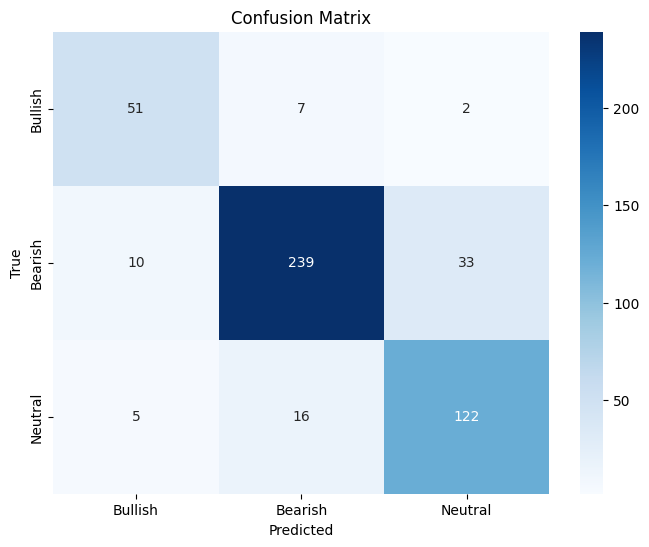

In [ ]:
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# Load Confusion Matrix
confusion_matrix = np.load(f"{results_bert_full['output_dir']}/confusion_matrix.npy")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bullish", "Bearish", "Neutral"], yticklabels=["Bullish", "Bearish", "Neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




## 2). BERT LoRA Fine-Tune

In [4]:
# BERT LoRA
model_name = "bert-base-uncased"
print(f"Training {model_name} LoRA")

# Train BERT-LoRA Model
results_bert_lora = run_experiment(
    model_name=model_name, strategy="lora", use_lora=True, lr=LR_LORA
)

Training bert-base-uncased LoRA

MODEL: bert-base-uncased | STRATEGY: lora | LR=0.0001


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,341,699 || all params: 110,826,246 || trainable%: 1.2106


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.728100,0.610525,0.721649,0.642835
2,0.312300,0.432366,0.802062,0.775665
3,0.294300,0.411851,0.816495,0.784181


[WARN] SHAP block failed: name 'run_shap_block_safe' is not defined

[PROFILE] time=179.20s, throughput=86.52 samples/s, trainable_params=1,341,699, peak_mem=1169.9MB
[TEST] Acc=0.8247 | F1(macro)=0.7972


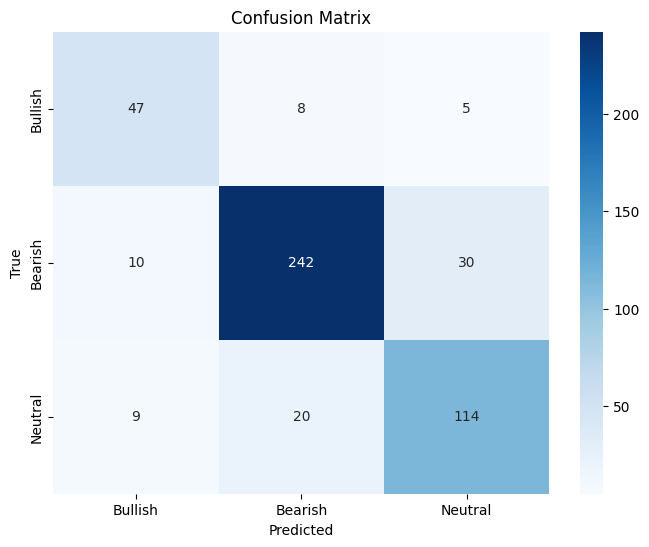

In [ ]:
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# Load COnfusion Matrix
confusion_matrix = np.load(f"{results_bert_lora['output_dir']}/confusion_matrix.npy")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bullish", "Bearish", "Neutral"], yticklabels=["Bullish", "Bearish", "Neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 3). finBERT Full Fine-Tune

In [5]:
# FinBERT Full Fine-Tune
model_name = "ProsusAI/finbert"
print(f"Training {model_name} Full Fine-Tune")

# Train Full Fine-Tune Model
results_finbert_full = run_experiment(
    model_name=model_name, strategy="full_finetune", use_lora=False, lr=LR_FULL
)


Training ProsusAI/finbert Full Fine-Tune

MODEL: ProsusAI/finbert | STRATEGY: full_finetune | LR=2e-05


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.419000,0.374020,0.855670,0.842286
2,0.090300,0.477582,0.859794,0.847633
3,0.052600,0.449860,0.884536,0.867858


[WARN] SHAP block failed: name 'run_shap_block_safe' is not defined

[PROFILE] time=131.40s, throughput=117.99 samples/s, trainable_params=109,484,547, peak_mem=2321.6MB
[TEST] Acc=0.8577 | F1(macro)=0.8400


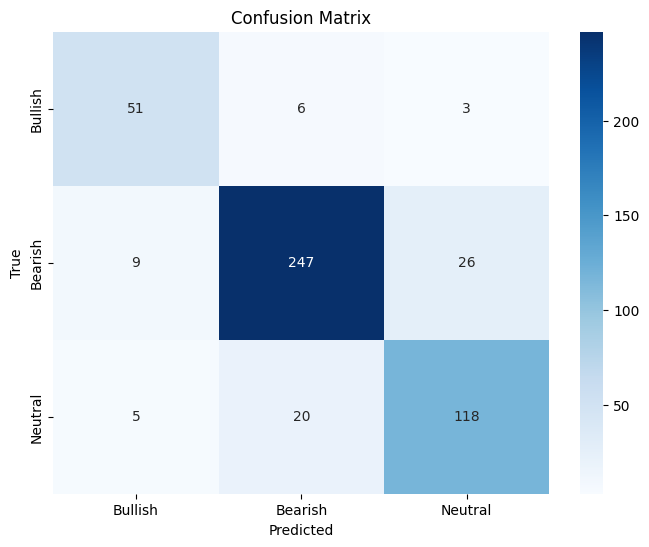

In [ ]:
# Load Confusion Matrix
confusion_matrix = np.load(f"{results_finbert_full['output_dir']}/confusion_matrix.npy")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bullish", "Bearish", "Neutral"], yticklabels=["Bullish", "Bearish", "Neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4. finBERT LoRA Fine-Tune

In [6]:
model_name = "ProsusAI/finbert"
print(f"Training {model_name} LoRA")

# Train FinBERT LoRA Model
results_finbert_lora = run_experiment(
    model_name=model_name, strategy="lora", use_lora=True, lr=LR_LORA
)

Training ProsusAI/finbert LoRA

MODEL: ProsusAI/finbert | STRATEGY: lora | LR=0.0001


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


trainable params: 1,341,699 || all params: 110,826,246 || trainable%: 1.2106


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.303400,0.289556,0.901031,0.893030
2,0.180700,0.298990,0.894845,0.886518
3,0.204300,0.290123,0.903093,0.894693


[WARN] SHAP block failed: name 'run_shap_block_safe' is not defined

[PROFILE] time=177.70s, throughput=87.25 samples/s, trainable_params=1,341,699, peak_mem=1703.2MB
[TEST] Acc=0.8784 | F1(macro)=0.8667


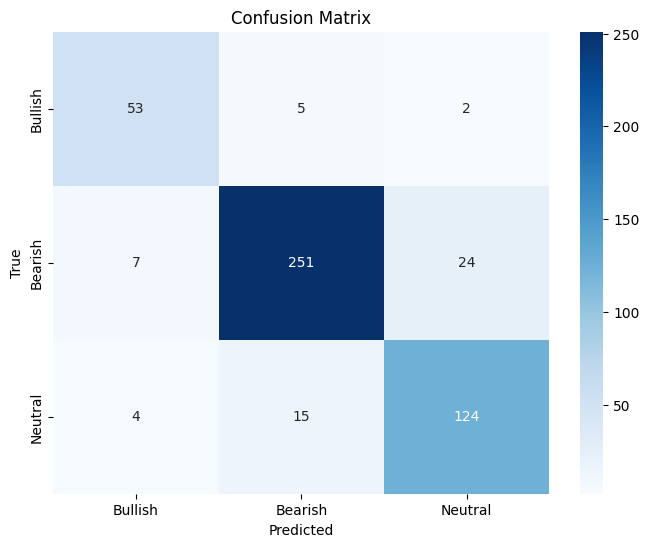

In [ ]:
# Load Confusion Matrix
confusion_matrix = np.load(f"{results_finbert_lora['output_dir']}/confusion_matrix.npy")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bullish", "Bearish", "Neutral"], yticklabels=["Bullish", "Bearish", "Neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()